# MIND: Microsoft News Recommendation
Source: a part of the code of the jupyter is from Microsoft recommenders github.

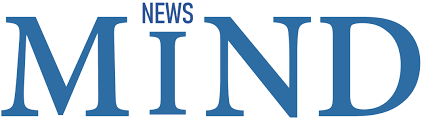

**MIcrosoft News Dataset (MIND)** is a large-scale dataset for news recommendation research. It was collected from anonymized behavior logs of Microsoft News website. The mission of MIND is to serve as a benchmark dataset for news recommendation and facilitate the research in news recommendation and recommender systems area.

MIND contains about **160k English news** articles and **more than 15 million impression logs** generated by **1 million users**. Every news article contains rich textual content including title, abstract, body, category and entities. Each impression log contains the click events, non-clicked events and historical news click behaviors of this user before this impression

<a id='1'></a>
# Importing The Packages

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline
# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity  
# from lightgbm import LGBMClassifier
from sklearn.metrics import pairwise_distances
import copy
from IPython.display import clear_output
import warnings
# from eli5.lime.samplers import MaskingTextSampler
from re import sub
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plotly.offline.init_notebook_mode (connected = True)
# import eli5
from sklearn import metrics
from sklearn.model_selection import train_test_split
from PIL import Image 
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from xgboost import XGBClassifier
import random
import kaleido
warnings.filterwarnings("ignore")

<a id='2'></a>
# Importing the data

In [3]:
# MINDsmall_train
raw_behaviour = pd.read_csv(
    "MIND/mind_version1/MIND_Demo_Version1/valid/behaviors.tsv",  # MIND/mind_version1/MIND_Demo_Version1/train/behaviors.tsv MIND/MINDlarge/train/behaviors.tsv
    sep="\t",
    names=["impressionId" ,"userId","timestamp","click_history","impressions"])

print(f"The dataset consist of {len(raw_behaviour)} number of interactions.")
raw_behaviour.head()

The dataset consist of 7538 number of interactions.


,impressionId,userId,timestamp,click_history,impressions
0,1,U41827,11/15/2019 2:41:03 PM,N15366 N12202 N27489 N19773 N21134 N18191 N686...,N23699-0 N21291-0 N1901-0 N27292-0 N17443-0 N1...
1,2,U61881,11/15/2019 10:31:42 AM,N16469 N4202 N4202 N21816 N12992 N24242 N7366 ...,N26916-0 N4641-0 N25522-0 N14893-0 N19035-0 N3...
2,3,U54180,11/15/2019 5:36:17 AM,N22427 N16386 N24242 N4385 N14672 N12242 N1852...,N13528-0 N27689-0 N10879-0 N11662-0 N14409-0 N...
3,4,U41164,11/15/2019 9:13:44 AM,N13065 N5748 N12658 N276 N7395 N16010 N13761 N...,N20150-0 N1807-1 N26916-0 N28138-0 N9576-0 N19...
4,5,U8588,11/15/2019 5:39:04 AM,N6629 N4958 N10917 N27079 N828,N21325-0 N5982-0 N19737-1 N9576-0 N20150-0 N25...


In [4]:
raw_behaviour_1 = raw_behaviour [["impressionId" , "impressions"]]
raw_behaviour_1

,impressionId,impressions
0,1,N23699-0 N21291-0 N1901-0 N27292-0 N17443-0 N1...
1,2,N26916-0 N4641-0 N25522-0 N14893-0 N19035-0 N3...
2,3,N13528-0 N27689-0 N10879-0 N11662-0 N14409-0 N...
3,4,N20150-0 N1807-1 N26916-0 N28138-0 N9576-0 N19...
4,5,N21325-0 N5982-0 N19737-1 N9576-0 N20150-0 N25...
...,...,...
7533,7534,N26256-0 N28117-0 N2718-0 N16798-0 N27689-0 N6...
7534,7535,N26670-0 N12794-0 N3390-0 N17443-0 N27292-0 N2...
7535,7536,N17443-0 N16798-0 N24553-0 N26096-0 N15927-0 N...
7536,7537,N14850-0 N26647-0 N272-0 N22751-0 N21398-0 N26...


In [5]:
## Indexize users
unique_userIds = raw_behaviour['userId'].unique()
# Allocate a unique index for each user, but let the zeroth index be a UNK index:
ind2user = {idx +1: userid for idx, userid in enumerate(unique_userIds)}
user2ind = {userid : idx for idx, userid in ind2user.items()}
print(f"We have {len(user2ind)} unique users in the dataset")

# Create a new column with userIdx:
raw_behaviour['userIdx'] = raw_behaviour['userId'].map(lambda x: user2ind.get(x,0))
# raw_behaviour#.head(5)

We have 5000 unique users in the dataset


In [6]:
len (raw_behaviour.userId.unique())

5000

In [22]:
news = pd.read_csv(
    "MIND/mind_version1/MIND_Demo_Version1/valid/news.tsv",  # MIND/MINDlarge/train/news.tsv
    sep="\t",
    names=["itemId","category","subcategory","title","abstract","url","title_entities","abstract_entities"])
news.head(2)
# Build index of items
ind2item = {idx +1: itemid for idx, itemid in enumerate(news['itemId'].values)}
item2ind = {itemid : idx for idx, itemid in ind2item.items()}


In [23]:
news.category.unique()

array(['lifestyle', 'news', 'health', 'weather', 'entertainment', 'autos',
       'travel', 'sports', 'tv', 'foodanddrink', 'movies', 'finance',
       'video', 'music', 'middleeast', 'kids'], dtype=object)

In [24]:
def process_NewsID(s):
    list_of_strings = str(s).split(" ")
    for l in list_of_strings:
        aa = item2ind.get(l, 0)
    return aa #item2ind.get(l, 0) for l in list_of_strings

In [25]:
# Indexize click history field
def process_click_history(s):
    list_of_strings = str(s).split(" ")
    return [item2ind.get(l, 0) for l in list_of_strings]
        
raw_behaviour['click_history_idx'] = raw_behaviour.click_history.map(lambda s:  process_click_history(s))
print (len (raw_behaviour))
raw_behaviour.head()

7538


,impressionId,userId,timestamp,click_history,impressions,userIdx,click_history_idx,noclicks,click
0,1,U41827,11/15/2019 2:41:03 PM,N15366 N12202 N27489 N19773 N21134 N18191 N686...,N23699-0 N21291-0 N1901-0 N27292-0 N17443-0 N1...,1,"[11869, 10709, 6673, 3110, 13247, 8917, 8635, ...","[N23699, N21291, N1901, N27292, N17443, N18282...",N8620
1,2,U61881,11/15/2019 10:31:42 AM,N16469 N4202 N4202 N21816 N12992 N24242 N7366 ...,N26916-0 N4641-0 N25522-0 N14893-0 N19035-0 N3...,2,"[3888, 8156, 8156, 13654, 6905, 6763, 10582, 9...","[N26916, N4641, N25522, N14893, N19035, N3877,...",N19829
2,3,U54180,11/15/2019 5:36:17 AM,N22427 N16386 N24242 N4385 N14672 N12242 N1852...,N13528-0 N27689-0 N10879-0 N11662-0 N14409-0 N...,3,"[3831, 7961, 6763, 3817, 14055, 14204, 1515, 1...","[N13528, N27689, N10879, N11662, N14409, N6849...",N13530
3,4,U41164,11/15/2019 9:13:44 AM,N13065 N5748 N12658 N276 N7395 N16010 N13761 N...,N20150-0 N1807-1 N26916-0 N28138-0 N9576-0 N19...,4,"[12699, 9017, 2988, 5390, 14100, 11664, 2797, ...","[N20150, N26916, N28138, N9576, N19737, N24553...",N16798
4,5,U8588,11/15/2019 5:39:04 AM,N6629 N4958 N10917 N27079 N828,N21325-0 N5982-0 N19737-1 N9576-0 N20150-0 N25...,5,"[10019, 2460, 12304, 1777, 10983]","[N21325, N5982, N9576, N20150, N25701, N10908,...",N19737


In [26]:
# collect one click and one no-click from impressions:
def process_impression(s):
    list_of_strings = s.split(" ")
    itemid_rel_tuple = [l.split("-") for l in list_of_strings]
    noclicks = []
    for entry in itemid_rel_tuple:
        if entry[1] =='0':
            noclicks.append(entry[0])
        if entry[1] =='1':
            click = entry[0]
    return noclicks, click

raw_behaviour['noclicks'], raw_behaviour['click'] = zip(*raw_behaviour['impressions'].map(process_impression))
# We can then indexize these two new columns:
# raw_behaviour['noclicks'] = raw_behaviour['noclicks'].map(lambda list_of_strings: [item2ind.get(l, 0) for l in list_of_strings])
# raw_behaviour['click'] = raw_behaviour['click'].map(lambda x: item2ind.get(x,0))
# raw_behaviour

In [27]:
# raw_behaviour['noclick'] = raw_behaviour['noclicks'].map(lambda x : x[0])
behaviour = raw_behaviour.copy () # raw_behaviour[['epochhrs','userId','click_history','noclick','click']]
behaviour = behaviour [["userId", "click_history"]]
behaviour['click_history'] = behaviour['click_history'].str.replace(' ', ',')
behaviour.head(5)

,userId,click_history
0,U41827,"N15366,N12202,N27489,N19773,N21134,N18191,N686..."
1,U61881,"N16469,N4202,N4202,N21816,N12992,N24242,N7366,..."
2,U54180,"N22427,N16386,N24242,N4385,N14672,N12242,N1852..."
3,U41164,"N13065,N5748,N12658,N276,N7395,N16010,N13761,N..."
4,U8588,"N6629,N4958,N10917,N27079,N828"


In [28]:
# Split the comma-separated strings into lists of items
behaviour['click_history'] = behaviour['click_history'].str.split(',')

# Explode the lists into multiple rows
df_exploded = behaviour.explode('click_history').reset_index(drop=True)
# Drop duplicated rows
df_expanded = df_exploded.drop_duplicates().reset_index(drop=True)


In [29]:
user_U10062 = df_expanded[df_expanded['userId'] == 'U10062']
user_U10062


,userId,click_history
133564,U10062,N24319
133565,U10062,N13733
133566,U10062,N21481
133567,U10062,N5724
133568,U10062,N989
...,...,...
133700,U10062,N20753
133701,U10062,N22194
133702,U10062,N16008
133703,U10062,N10231


In [30]:
explode_behaviour = df_expanded.copy ()

In [31]:
# data=pd.read_csv('MIND/MINDsmall_train/news.tsv',header=None,sep='\t')
data = news.copy ()
# data.head (5)

In [32]:
# Can I merge userIdx, click_history_idx, with categoy and subcategory? 
behaviour_News = pd.merge(explode_behaviour, data,  how='left', left_on=['click_history'], right_on = ['itemId']) # ItemID
behaviour_News#.head(5)

,userId,click_history,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,U41827,N15366,N15366,sports,more_sports,High school soccer: Chloe DeLyser sets record ...,"Chloe DeLyser, an Ohio State commit, scored he...",https://www.msn.com/en-us/sports/more-sports/h...,[],[]
1,U41827,N12202,N12202,sports,football_nfl,NFL players who should be traded before the de...,"The NFL trade deadline is Oct. 29, and if rece...",https://www.msn.com/en-us/sports/football_nfl/...,"[{""Label"": ""National Football League"", ""Type"":...","[{""Label"": ""National Football League"", ""Type"":..."
2,U41827,N27489,N27489,news,newsus,"Missing Minnesota boy, 6, and his dog, found i...",A missing 6-year-old boy from Minnesota and hi...,https://www.msn.com/en-us/news/us/missing-minn...,"[{""Label"": ""Minnesota"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Minnesota"", ""Type"": ""G"", ""Wikidata..."
3,U41827,N19773,N19773,news,newsworld,Trump appears to confirm U.S. nukes are in Tur...,Asked about the U.S.'s reported stockpile in T...,https://www.msn.com/en-us/news/newsworld/trump...,"[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""..."
4,U41827,N21134,N21134,news,newsworld,"Three gunmen killed in Brazil airport raid, ki...",Heavily armed gunmen raided an airport in Braz...,https://www.msn.com/en-us/news/world/three-gun...,"[{""Label"": ""Brazil"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Brazil"", ""Type"": ""G"", ""WikidataId""..."
...,...,...,...,...,...,...,...,...,...,...
136558,U92611,N11487,N11487,news,newsworld,Hundreds arrested ahead of verdict on Indian h...,Indian police have arrested more than 500 peop...,https://www.msn.com/en-us/news/newsworld/hundr...,[],"[{""Label"": ""Ayodhya"", ""Type"": ""G"", ""WikidataId..."
136559,U92611,N8592,N8592,news,newsus,NRA drops lawsuit over San Francisco's 'terror...,SAN FRANCISCO (AP) The National Rifle Associ...,https://www.msn.com/en-us/news/us/nra-drops-la...,"[{""Label"": ""San Francisco"", ""Type"": ""G"", ""Wiki...","[{""Label"": ""San Francisco"", ""Type"": ""G"", ""Wiki..."
136560,U92611,N13915,N13915,travel,travelarticle,First NoVA Location Of Restaurant Chain About ...,Muslim woman's historic win | Capitol Christma...,https://www.msn.com/en-us/travel/travelarticle...,"[{""Label"": ""Chain store"", ""Type"": ""C"", ""Wikida...",[]
136561,U92611,N18479,N18479,news,elections-2020-us,Trump's 2016 team sounds alarm as Democrats ma...,Senior members of President Trump's 2016 campa...,https://www.msn.com/en-us/news/elections-2020-...,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid..."


In [33]:
# grouped_df= df_filtered.copy()
# Number of unique user_ids and book_ids
num_unique_users = behaviour_News['userId'].nunique() # userIdx
num_unique_books = behaviour_News['itemId'].nunique() # ItemID
num_unique_news_hist = behaviour_News['click_history'].nunique() # click_history_idx

# Total possible interactions (assuming all combinations exist)
total_possible_interactions = num_unique_users * num_unique_books

# Actual number of interactions (non-zero ratings)
num_interactions = behaviour_News.shape[0]

# Sparsity calculation
sparsity = 1.0 - (num_interactions / total_possible_interactions)

# Print the results
print(f"Number of unique user_ids: {num_unique_users}")
print(f"Number of unique news_ids: {num_unique_books}")
print(f"Number of unique news_ids: {num_unique_news_hist}")

print(f"Sparsity of the data: {sparsity:.4f}")

Number of unique user_ids: 5000
Number of unique news_ids: 15557
Number of unique news_ids: 15557
Sparsity of the data: 0.9982


## MIND Demo 
Number of unique user_ids: 5000

Number of unique news_ids: 15557

Number of unique news_ids: 15557

Sparsity of the data: 0.9871


Number of unique user_ids: 5000 Number of unique news_ids: 77 Number of unique news_ids: 4844
Sparsity of the data: 0.9428

MINDlarge:
Number of unique user_ids: 711222

Number of unique news_ids: 79546

Number of unique news_ids: 79546

Sparsity of the data: 0.9998

In [34]:
# Group by 'user_id' and count the ratings for each user
user_ratings_counts = behaviour_News.groupby('userId')['click_history'].count()

# Sort the user ratings counts in descending order
sorted_user_ratings_counts = np.sort(user_ratings_counts)[::-1]

# If you want to sort in descending order but preserve the corresponding user IDs:
sorted_user_ids = user_ratings_counts.index[np.argsort(user_ratings_counts.values)[::-1]]

# If you want to see both user IDs and their corresponding counts:
sorted_user_data = pd.DataFrame({'userIdx': sorted_user_ids, 'rating_count': sorted_user_ratings_counts})
sorted_user_data

,userIdx,rating_count
0,U79210,343
1,U79449,336
2,U54826,304
3,U71659,272
4,U44210,259
...,...,...
4995,U85195,0
4996,U22283,0
4997,U44217,0
4998,U4411,0


In [35]:
selected_data = behaviour_News.copy()#[behaviour_News['userId'].isin(behaviour_News['userId'].unique()[:1000])]
len (selected_data.userId.unique())
selected_data

,userId,click_history,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,U41827,N15366,N15366,sports,more_sports,High school soccer: Chloe DeLyser sets record ...,"Chloe DeLyser, an Ohio State commit, scored he...",https://www.msn.com/en-us/sports/more-sports/h...,[],[]
1,U41827,N12202,N12202,sports,football_nfl,NFL players who should be traded before the de...,"The NFL trade deadline is Oct. 29, and if rece...",https://www.msn.com/en-us/sports/football_nfl/...,"[{""Label"": ""National Football League"", ""Type"":...","[{""Label"": ""National Football League"", ""Type"":..."
2,U41827,N27489,N27489,news,newsus,"Missing Minnesota boy, 6, and his dog, found i...",A missing 6-year-old boy from Minnesota and hi...,https://www.msn.com/en-us/news/us/missing-minn...,"[{""Label"": ""Minnesota"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Minnesota"", ""Type"": ""G"", ""Wikidata..."
3,U41827,N19773,N19773,news,newsworld,Trump appears to confirm U.S. nukes are in Tur...,Asked about the U.S.'s reported stockpile in T...,https://www.msn.com/en-us/news/newsworld/trump...,"[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""..."
4,U41827,N21134,N21134,news,newsworld,"Three gunmen killed in Brazil airport raid, ki...",Heavily armed gunmen raided an airport in Braz...,https://www.msn.com/en-us/news/world/three-gun...,"[{""Label"": ""Brazil"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Brazil"", ""Type"": ""G"", ""WikidataId""..."
...,...,...,...,...,...,...,...,...,...,...
136558,U92611,N11487,N11487,news,newsworld,Hundreds arrested ahead of verdict on Indian h...,Indian police have arrested more than 500 peop...,https://www.msn.com/en-us/news/newsworld/hundr...,[],"[{""Label"": ""Ayodhya"", ""Type"": ""G"", ""WikidataId..."
136559,U92611,N8592,N8592,news,newsus,NRA drops lawsuit over San Francisco's 'terror...,SAN FRANCISCO (AP) The National Rifle Associ...,https://www.msn.com/en-us/news/us/nra-drops-la...,"[{""Label"": ""San Francisco"", ""Type"": ""G"", ""Wiki...","[{""Label"": ""San Francisco"", ""Type"": ""G"", ""Wiki..."
136560,U92611,N13915,N13915,travel,travelarticle,First NoVA Location Of Restaurant Chain About ...,Muslim woman's historic win | Capitol Christma...,https://www.msn.com/en-us/travel/travelarticle...,"[{""Label"": ""Chain store"", ""Type"": ""C"", ""Wikida...",[]
136561,U92611,N18479,N18479,news,elections-2020-us,Trump's 2016 team sounds alarm as Democrats ma...,Senior members of President Trump's 2016 campa...,https://www.msn.com/en-us/news/elections-2020-...,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid..."


In [36]:
## Indexize users
unique_userIds = selected_data['userId'].unique()
unique_itemIds = selected_data['click_history'].unique()

# Allocate a unique index for each user, but let the zeroth index be a UNK index:
ind2user = {idx +1: userid for idx, userid in enumerate(unique_userIds)}
user2ind = {userid : idx for idx, userid in ind2user.items()}
print(f"We have {len(user2ind)} unique users in the dataset")

ind2item = {idx +1: itemid for idx, itemid in enumerate(unique_itemIds)}
item2ind = {itemid : idx for idx, itemid in ind2item.items()}
print(f"We have {len(item2ind)} unique items in the dataset")
# Create a new column with userIdx:
selected_data['userIdx'] = selected_data['userId'].map(lambda x: user2ind.get(x,0))
selected_data['itemIdx'] = selected_data['click_history'].map(lambda x: item2ind.get(x,0))
selected_data #.columns
# behav_news_cat.head(5)

We have 5000 unique users in the dataset
We have 15558 unique items in the dataset


,userId,click_history,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities,userIdx,itemIdx
0,U41827,N15366,N15366,sports,more_sports,High school soccer: Chloe DeLyser sets record ...,"Chloe DeLyser, an Ohio State commit, scored he...",https://www.msn.com/en-us/sports/more-sports/h...,[],[],1,1
1,U41827,N12202,N12202,sports,football_nfl,NFL players who should be traded before the de...,"The NFL trade deadline is Oct. 29, and if rece...",https://www.msn.com/en-us/sports/football_nfl/...,"[{""Label"": ""National Football League"", ""Type"":...","[{""Label"": ""National Football League"", ""Type"":...",1,2
2,U41827,N27489,N27489,news,newsus,"Missing Minnesota boy, 6, and his dog, found i...",A missing 6-year-old boy from Minnesota and hi...,https://www.msn.com/en-us/news/us/missing-minn...,"[{""Label"": ""Minnesota"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Minnesota"", ""Type"": ""G"", ""Wikidata...",1,3
3,U41827,N19773,N19773,news,newsworld,Trump appears to confirm U.S. nukes are in Tur...,Asked about the U.S.'s reported stockpile in T...,https://www.msn.com/en-us/news/newsworld/trump...,"[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Turkey"", ""Type"": ""G"", ""WikidataId""...",1,4
4,U41827,N21134,N21134,news,newsworld,"Three gunmen killed in Brazil airport raid, ki...",Heavily armed gunmen raided an airport in Braz...,https://www.msn.com/en-us/news/world/three-gun...,"[{""Label"": ""Brazil"", ""Type"": ""G"", ""WikidataId""...","[{""Label"": ""Brazil"", ""Type"": ""G"", ""WikidataId""...",1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
136558,U92611,N11487,N11487,news,newsworld,Hundreds arrested ahead of verdict on Indian h...,Indian police have arrested more than 500 peop...,https://www.msn.com/en-us/news/newsworld/hundr...,[],"[{""Label"": ""Ayodhya"", ""Type"": ""G"", ""WikidataId...",5000,9433
136559,U92611,N8592,N8592,news,newsus,NRA drops lawsuit over San Francisco's 'terror...,SAN FRANCISCO (AP) The National Rifle Associ...,https://www.msn.com/en-us/news/us/nra-drops-la...,"[{""Label"": ""San Francisco"", ""Type"": ""G"", ""Wiki...","[{""Label"": ""San Francisco"", ""Type"": ""G"", ""Wiki...",5000,12150
136560,U92611,N13915,N13915,travel,travelarticle,First NoVA Location Of Restaurant Chain About ...,Muslim woman's historic win | Capitol Christma...,https://www.msn.com/en-us/travel/travelarticle...,"[{""Label"": ""Chain store"", ""Type"": ""C"", ""Wikida...",[],5000,14263
136561,U92611,N18479,N18479,news,elections-2020-us,Trump's 2016 team sounds alarm as Democrats ma...,Senior members of President Trump's 2016 campa...,https://www.msn.com/en-us/news/elections-2020-...,"[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Donald Trump"", ""Type"": ""P"", ""Wikid...",5000,8838


In [38]:
selected_data.to_csv ("MIND/mind_version1/MIND_Demo_Version1/valid/behaviour_News_valid.csv", index=False) # MIND/MINDlarge/train/behaviour_News_train.csv
behaviour_News_interaction= selected_data [["userIdx", "itemIdx"]]
# behaviour_News_interaction ['rating'] = 1
behaviour_News_interaction.to_csv ("MIND/mind_version1/MIND_Demo_Version1/valid/behaviour_News_interaction_valid.csv", index=False, header=False) # MIND/MINDlarge/train/behaviour_News_interaction_train.csv
behaviour_News_interaction

,userIdx,itemIdx
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
136558,5000,9433
136559,5000,12150
136560,5000,14263
136561,5000,8838


<a id='4'></a>
# Selecting the needed columns

In [22]:
data=data.iloc[:,:5]
data.head()

,itemId,category,subcategory,title,abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


<a id='5'></a>
# Visualizing The Data

<a id='5.1'></a>
# Category and Subcategory distribution in data

In [24]:
c=data[['category','subcategory']].value_counts()


In [25]:
index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

In [26]:
df=pd.DataFrame(columns=['Category','Sub Category','Values'])
df['Category']=index[:,0]
df['Sub Category']=index[:,1]
df['Values']=c.values

In [27]:
df

,Category,Sub Category,Values
0,news,newsus,6564
1,sports,football_nfl,5420
2,news,newspolitics,2826
3,news,newscrime,2254
4,weather,weathertopstories,2047
...,...,...,...
278,finance,finance-home-loans,1
279,finance,finance-homesandpropertysection,1
280,news,newsnational,1
281,news,narendramodi_opinion,1


In [9]:
px.bar(data_frame=df,x='Category',y='Values',color='Sub Category')


### From this we can clearly see that the most of the news was on the Category of news with subcategory newsus followed by sports with football news

<a id='5.2'></a>
# WordCloud For Sports News

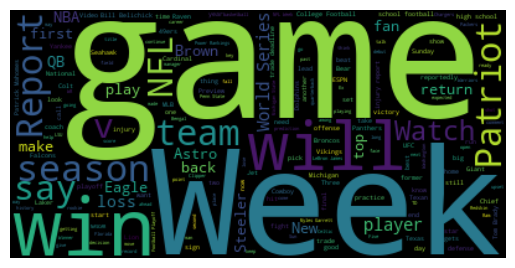

In [10]:
text=' '
for i in data[data['Category']=='sports']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()


<a id='5.3'></a>
# Wordcloud for news

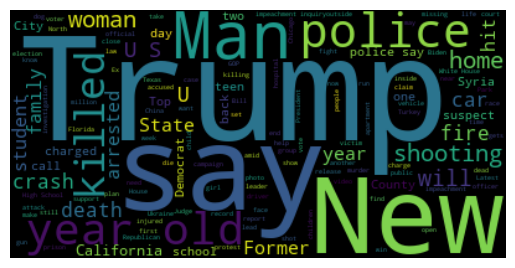

In [11]:
text=' '
for i in data[data['Category']=='news']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()


Wow the main attraction of news has been Trump :)